#1. 데이터 입력


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import figure_factory as figfac

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
from sklearn.metrics import mean_squared_error

In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 13.3 MB/s 
     |████████████████████████████████| 1.6 MB 19.9 MB/s 


In [ ]:
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
df = pd.read_csv("/gold.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,289.5,289.5,280.0,283.7,21621,USD
1,2000-01-05,283.7,285.0,281.0,282.1,25448,USD
2,2000-01-06,281.6,282.8,280.2,282.4,19055,USD
3,2000-01-07,282.5,284.5,282.0,282.9,11266,USD
4,2000-01-10,282.4,283.9,281.8,282.7,30603,USD


#2. 전처리 과정
###1) 데이터 확인

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5703 entries, 0 to 5702
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5703 non-null   object 
 1   Open      5703 non-null   float64
 2   High      5703 non-null   float64
 3   Low       5703 non-null   float64
 4   Close     5703 non-null   float64
 5   Volume    5703 non-null   int64  
 6   Currency  5703 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 312.0+ KB


In [ ]:
df.describe()

,Open,High,Low,Close,Volume
count,5703.000000,5703.000000,5703.000000,5703.000000,5703.000000
mean,1040.382816,1048.339181,1031.863169,1040.298282,139141.669297
std,518.733377,522.353946,514.455903,518.524020,102537.449058
min,256.600000,259.400000,255.100000,256.600000,0.000000
25%,459.850000,463.900000,457.450000,460.500000,52938.500000
50%,1188.800000,1198.000000,1179.700000,1188.700000,126006.000000
75%,1381.400000,1392.750000,1368.100000,1383.050000,193109.000000
max,2076.400000,2089.200000,2049.000000,2069.400000,816531.000000


In [ ]:
df.rename(columns = {"Date" : "date", "Open" : "open", "High" : "high", "Low" : "low", "Close" : "close", "Volume" : "volume", "Currency" : "currency"}, inplace = True)
df.describe()

,open,high,low,close,volume
count,5703.000000,5703.000000,5703.000000,5703.000000,5703.000000
mean,1040.382816,1048.339181,1031.863169,1040.298282,139141.669297
std,518.733377,522.353946,514.455903,518.524020,102537.449058
min,256.600000,259.400000,255.100000,256.600000,0.000000
25%,459.850000,463.900000,457.450000,460.500000,52938.500000
50%,1188.800000,1198.000000,1179.700000,1188.700000,126006.000000
75%,1381.400000,1392.750000,1368.100000,1383.050000,193109.000000
max,2076.400000,2089.200000,2049.000000,2069.400000,816531.000000


In [ ]:
print("Shape of the dataset: ", df.shape)
print("Length of the dataset: ", len(df))
print("Maximum closing price of gold during last twenty two years: ", df["close"].max())
print("Minimum closing price of gold during last twenty two years: ", df["close"].min())

Shape of the dataset:  (5703, 7)
Length of the dataset:  5703
Maximum closing price of gold during last twenty two years:  2069.4
Minimum closing price of gold during last twenty two years:  256.6


In [ ]:
df.corr()

,open,high,low,close,volume
open,1.000000,0.999879,0.999825,0.999740,0.692123
high,0.999879,1.000000,0.999778,0.999861,0.693861
low,0.999825,0.999778,1.000000,0.999893,0.688983
close,0.999740,0.999861,0.999893,1.000000,0.690534
volume,0.692123,0.693861,0.688983,0.690534,1.000000


#데이터 전처리 (데이터 시각화)

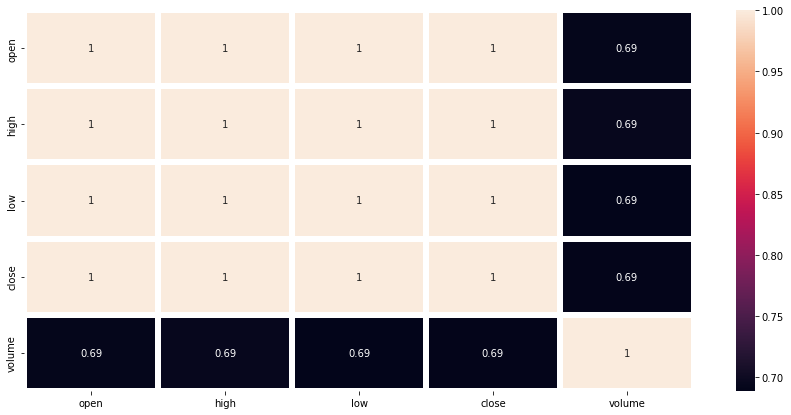

In [ ]:
plt.figure(figsize = [15, 7])
sns.heatmap(df.corr(), annot = True, linewidths = 5)

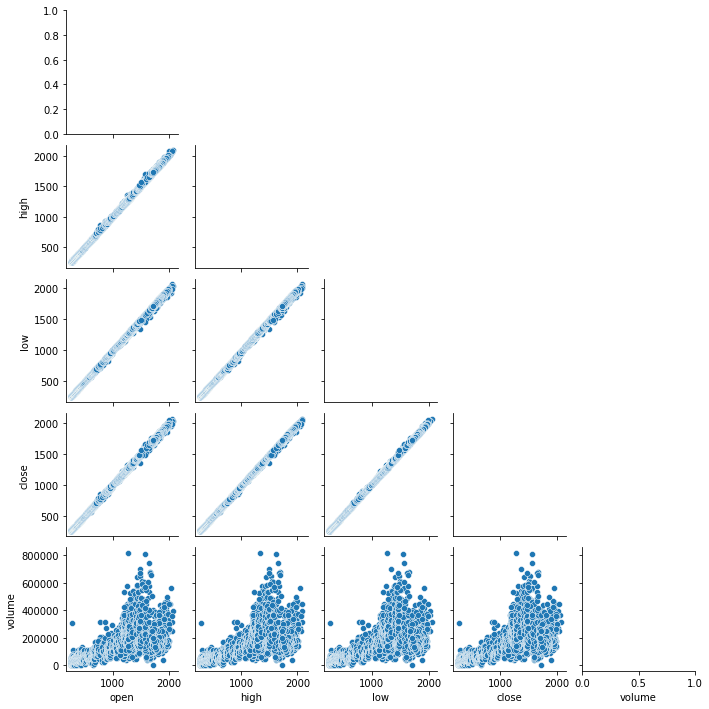

In [ ]:
sns.pairplot(df, diag_kind = "reg", height = 2, aspect = 1, corner = True);

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_te

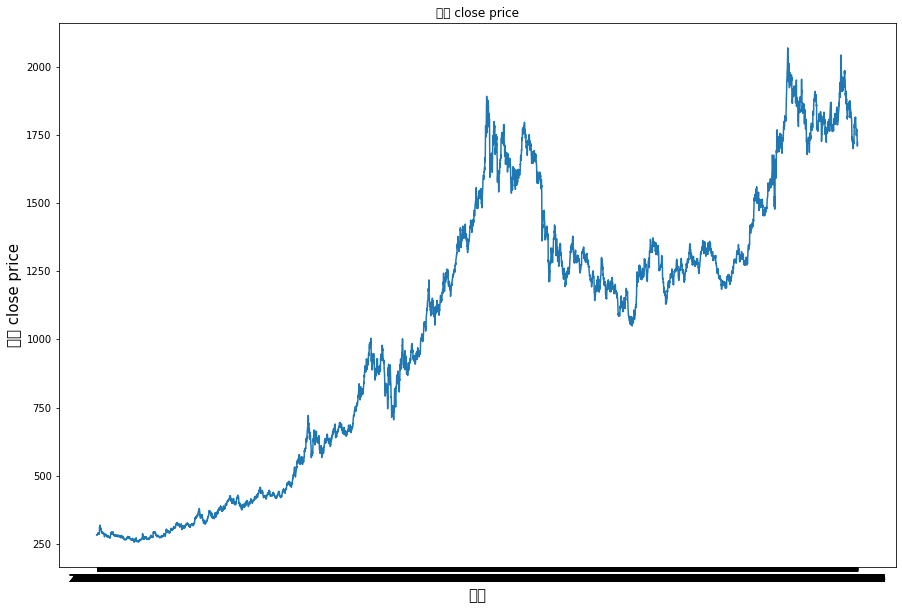

In [ ]:
fig = plt.figure(figsize = (15, 10))

plt.plot(df["date"], df["close"])
plt.title("금의 close price")
plt.xlabel("날짜", fontsize = 15)
plt.ylabel("금의 close price", fontsize = 15)
plt.show()

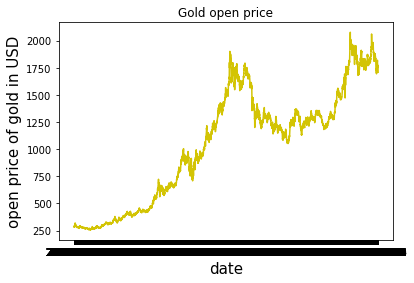

In [ ]:
plt.figure()

plt.plot(df["date"], df["open"], color = "#D3C404")
plt.title("Gold open price")
plt.xlabel("date", fontsize = 15)
plt.ylabel("open price of gold in USD", fontsize = 15)
plt.show()

In [ ]:
fig = px.histogram(df, x = "close", y = "volume", marginal = "box", text_auto = True, hover_data  = df.columns)
fig.show()

#데이터 전처리
###데이터 가공

In [ ]:
data = df.filter(['close'])
data.head()

,close
0,283.7
1,282.1
2,282.4
3,282.9
4,282.7


In [ ]:
dataset = data.values
dataset[0:5]

array([[283.7],
       [282.1],
       [282.4],
       [282.9],
       [282.7]])

In [ ]:
training_data_len = int(np.ceil( len(dataset) * .95 ))
print("Training data length: ", training_data_len)

Training data length:  5418


### 1) 데이터 정규화
Minmax Scaler을 사용해서 0~1사이의 값으로 바꾸어 준다.

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

NameError: ignored

###2) 데이터 나누기
Train과 Test 셋을 나누어 준다.

In [ ]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train, "\n")
        print(y_train)

[array([0.01494925, 0.01406664, 0.01423213, 0.01450794, 0.01439762,
       0.01533539, 0.01494925, 0.01572154, 0.01561121, 0.01820388,
       0.01859003, 0.01803839, 0.01825905, 0.01737643, 0.01654898,
       0.01649382, 0.0168248 , 0.01621801, 0.01632833, 0.01588703,
       0.01715578, 0.01836937, 0.03111209, 0.02642321, 0.02487864,
       0.02868491, 0.0342564 , 0.03144307, 0.03000883, 0.02620256,
       0.02669903, 0.02603707, 0.02796778, 0.02818844, 0.02526478,
       0.02443733, 0.02096205, 0.02074139, 0.02074139, 0.02024492,
       0.01825905, 0.01859003, 0.01809356, 0.02046558, 0.01864519,
       0.01991395, 0.01842454, 0.01925199, 0.01825905, 0.01820388,
       0.01676964, 0.01566637, 0.01649382, 0.01864519, 0.01748676,
       0.01588703, 0.01572154, 0.01318402, 0.01263239, 0.01064651])] 

[0.012411738746690215]
[array([0.01494925, 0.01406664, 0.01423213, 0.01450794, 0.01439762,
       0.01533539, 0.01494925, 0.01572154, 0.01561121, 0.01820388,
       0.01859003, 0.01803839, 0.

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
#Data Resetting
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("The sape of x_train set:", x_train.shape)

The sape of x_train set: (5358, 60, 1)


#3. 인공지능 모델 만들기
LSTM이용해서 인공지능 학습시키기


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = "adam", loss = "mean_squared_error")

model.fit(x_train, y_train, batch_size = 1, epochs = 1)

5358/5358 [==============================] - 58s 9ms/step - loss: 6.0210e-04


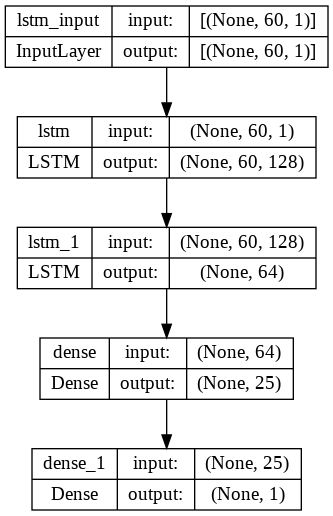

In [ ]:
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

  #데이터셋 뒤 60일을 제거하고 앞부분만 

In [ ]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions[0:10]

9/9 [==============================] - 1s 5ms/step


array([[1802.7552],
       [1799.8495],
       [1795.852 ],
       [1795.5586],
       [1794.996 ],
       [1793.8625],
       [1793.7926],
       [1794.0599],
       [1812.8226],
       [1815.6085]], dtype=float32)

In [ ]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("RMSE score of the model:", rmse)

RMSE score of the model: 20.26567717630265


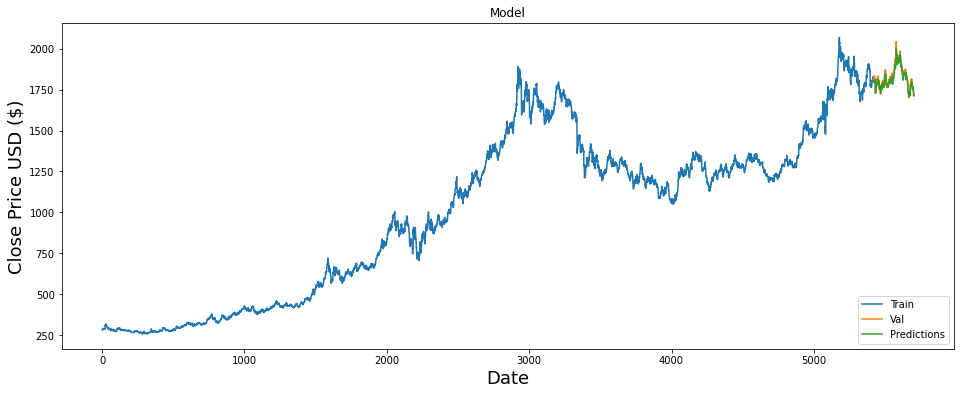

In [ ]:
#초록색 선 --> 예측한 결과
# 주황색 선 --> 실제 결과

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

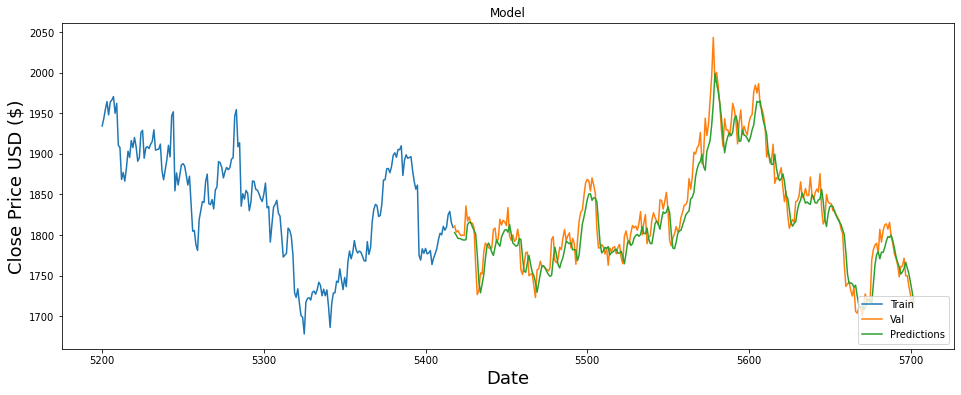

In [ ]:
# 예측한 부분 확대하기

train = data[5200:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [ ]:
valid.head(n = 10)

,close,Predictions
5418,1811.4,1802.755249
5419,1803.4,1799.849487
5420,1805.4,1795.852051
5421,1801.8,1795.558594
5422,1799.2,1794.995972
5423,1799.8,1793.862549
5424,1799.7,1793.792603
5425,1835.8,1794.059937
5426,1817.2,1812.822632
5427,1822.2,1815.608521


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

model2 = Sequential()
model2.add(SimpleRNN(128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model2.add(SimpleRNN(64, return_sequences = False))
model2.add(Dense(25))
model2.add(Dense(1))

model2.compile(optimizer = "adam", loss = "mean_squared_error")

model2.fit(x_train, y_train, batch_size = 1, epochs = 1) #에러 아님 다시 돌리세요. 내가 돌려놓기 귀찮음

5358/5358 [==============================] - 396s 74ms/step - loss: 0.0017


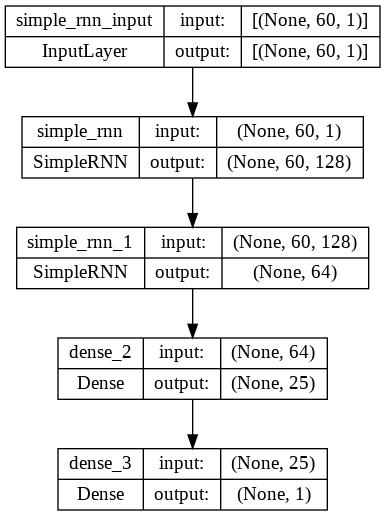

In [ ]:
keras.utils.plot_model(model2,show_shapes=True)

9/9 [==============================] - 0s 12ms/step
RMSE score of the model: 27.11364548718947


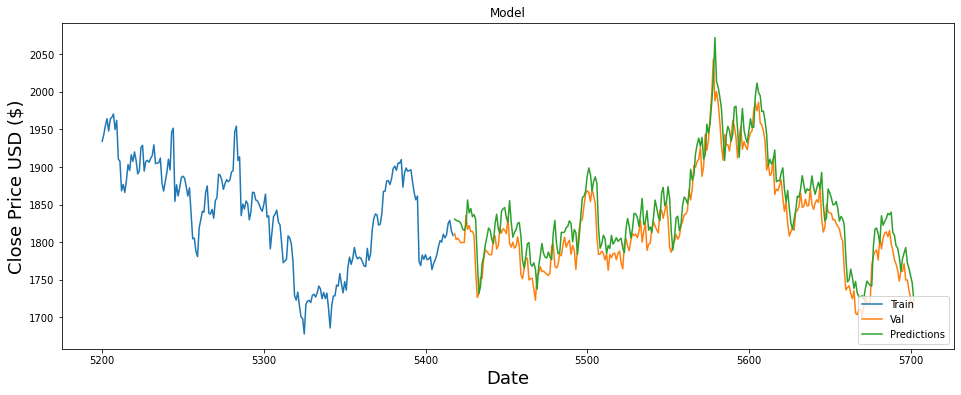

In [ ]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model2.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("RMSE score of the model:", rmse)

train = data[5200:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU

model3 = Sequential()
model3.add(GRU(128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model3.add(GRU(64, return_sequences = False))
model3.add(Dense(25))
model3.add(Dense(1))

model3.compile(optimizer = "adam", loss = "mean_squared_error")

model3.fit(x_train, y_train, batch_size = 1, epochs = 1)

5358/5358 [==============================] - 43s 8ms/step - loss: 5.4577e-04


9/9 [==============================] - 1s 5ms/step
RMSE score of the model: 68.64021267334643


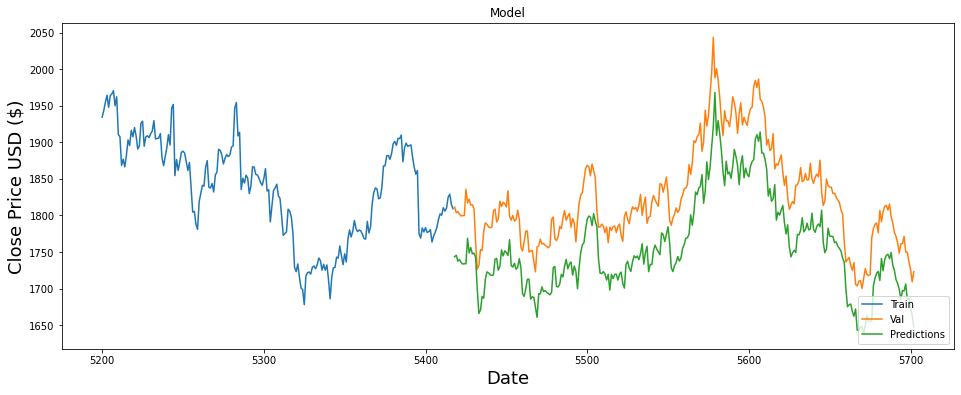

In [ ]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model3.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("RMSE score of the model:", rmse)

train = data[5200:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()